In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: MacOSX


In [2]:
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, cmap=custom_cmap)

## 初探决策树

莺尾花数据集，当前选取后面两个维度。莺尾花分为以下三类。

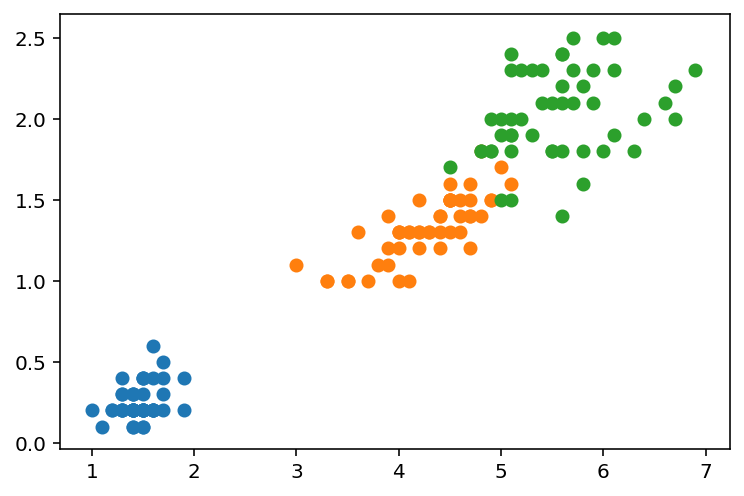

In [3]:
from sklearn import datasets

iris = datasets.load_iris()
x = iris.data[:, 2:]
y = iris.target

plt.scatter(x[y==0,0], x[y==0,1])
plt.scatter(x[y==1,0], x[y==1,1])
plt.scatter(x[y==2,0], x[y==2,1])
plt.show()

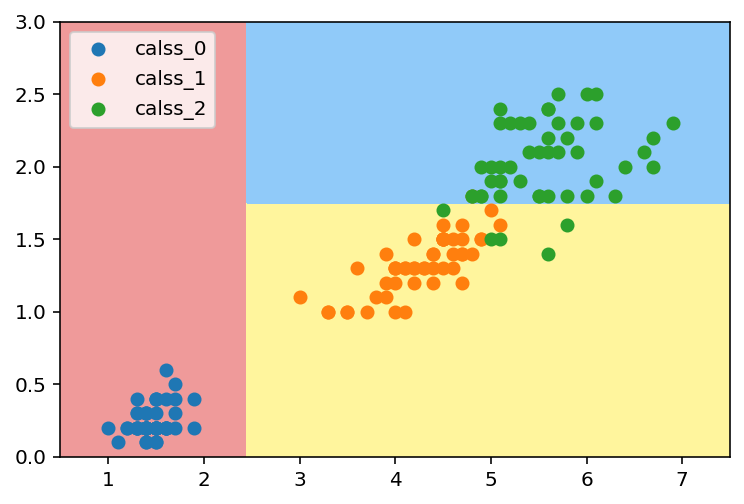

In [4]:
from sklearn.tree import DecisionTreeClassifier

# 设置树的深度为2, 使用信息熵
dt_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=42)
tree = dt_clf.fit(x, y)

plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(x[y==0,0], x[y==0,1], label='calss_0')
plt.scatter(x[y==1,0], x[y==1,1], label='calss_1')
plt.scatter(x[y==2,0], x[y==2,1], label='calss_2')
plt.legend()
plt.show()

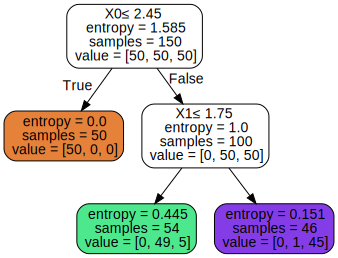

In [5]:
import graphviz 
from sklearn.tree import export_graphviz

dot_data = export_graphviz(dt_clf, filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph 

上述决策过程, 关键的点：

- 每个节点选择哪个维度做划分
- 维度上划分的阀值多少

可通过做优化信息熵或基尼系数，搜索到该节点上的维度和对应的阀值。

## 信息熵
计算公式:
$$
H=-\sum_{i=1}^{k} p_{i} \log \left(p_{i}\right)
$$



### 二分类信息熵
$$
H=-x \log (x)-(1-x) \log (1-x)
$$

eg: 计算以下场景的信息熵

场景一:

$$
\left\{\frac{1}{10}, \frac{2}{10}, \frac{7}{10}\right\}
$$

$$
H=-\frac{1}{10} \log \left(\frac{1}{10}\right)-\frac{2}{10} \log \left(\frac{2}{10}\right)-\frac{7}{10} \log \left(\frac{7}{10}\right)=0.8018
$$

场景二:

$$
\{1,0,0\}
$$

$$
H=-1 \cdot \log (1)=0
$$


结论:

场景一信息熵 < 场景二信息熵, 场景二更稳定。本来场景二里有一类概率为1,就是确定的，所以信息熵为0。 

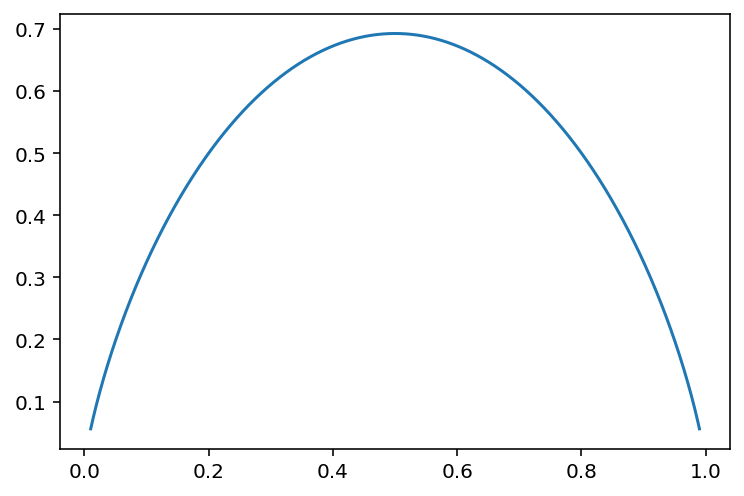

In [6]:
# 通过下图可看到，在0.5信息熵最大，不确定性越高；两级最小，比较稳定。
def second_category_entropy(p):
    """二分类问题信息熵"""
    return -p * np.log(p) - (1-p) * np.log(1-p)    

x_tmp = np.linspace(0.01, 0.99, 10000)
y_tmp = second_category_entropy(x_tmp)
plt.plot(x_tmp, y_tmp)

### 信息熵
基于信息熵实现决策树

In [7]:
from collections import Counter

def split(x, y, d, value): 
    left_index = (x[:, d] <= value)
    right_index = (x[:, d] > value)   
    return x[left_index], x[right_index], y[left_index], y[right_index]

def entropy(y):
    """信息熵"""
    counter = Counter(y)
    result = 0
    for num in counter.values():
        p = num / len(y)
        result += -p * np.log(p)
    return result

def decision_tree(x, y):
    best_entropy = float('inf')
    best_d, best_v = -1, -1
    
    for d in range(x.shape[1]):
        sorted_index = np.argsort(x[:, d])
        for i in range(1, len(x)):
            if x[sorted_index[i-1], d]!=x[sorted_index[i], d]:
                v = (x[sorted_index[i-1], d] + x[sorted_index[i], d]) / 2
                l_x, r_x, l_y, r_y = split(x, y, d, v)
                p_l, p_r = len(l_x)/len(x), len(r_x)/len(x)
                e = p_l * entropy(l_y) + p_r * entropy(r_y)
                if e < best_entropy:
                    best_entropy, best_d, best_v = e, d, v
    return best_entropy, best_d, best_v            

In [8]:
# 第一层级决策
best_entropy, best_d, best_v = decision_tree(x, y)
print('best_entropy: ', best_entropy)
print('best_d: ', best_d)
print('best_v: ', best_v)

best_entropy:  0.46209812037329684
best_d:  0
best_v:  2.45


结论
1. 信息熵为0.4620
2. best_d=0。因为在莺尾花散点图里使用第0维度绘制x轴，所以第一次决策判断阀值的维度使用第0维度，与sklearn里决策树算法结果一致；
3. best_v=2.45。阀值为2.45，与sklearn里决策树算法结果一致。

In [9]:
# 第二次决策
x1_l, x1_r, y1_l, y1_r = split(x, y, best_d, best_v)

best_entropy2, best_d2, best_v2 = decision_tree(x1_r, y1_r)
print('best_entropy2: ', best_entropy2)
print('best_d2: ', best_d2)
print('best_v2: ', best_v2)

best_entropy2:  0.2147644654371359
best_d2:  1
best_v2:  1.75


结论
1. 信息熵为0.4620
2. best_d2=1。第1个维度呈现在y轴，与sklearn里决策树算法结果一致；
3. best_v=1.75。阀值为1.75，与sklearn里决策树算法结果一致。

## 基尼系数
计算公式：
$$
G=1-\sum_{i=1}^{k} p_{i}^{2}
$$

案例一:

$$
\left\{\frac{1}{10}, \frac{2}{10}, \frac{7}{10}\right\}
$$

$$
G=1-\left(\frac{1}{10}\right)^{2}-\left(\frac{2}{10}\right)^{2}-\left(\frac{7}{10}\right)^{2}=0.46
$$

案例二:

$$
\{1,0,0\}
$$

$$
G=1-1^{2}=0
$$

场景一信息熵 < 场景二基尼系数, 场景二更稳定。本来场景二里有一类概率为1,就是确定的，所以基尼系数为0。 


### 二分类基尼系数
$$
G=-2 x^{2}+2 x
$$

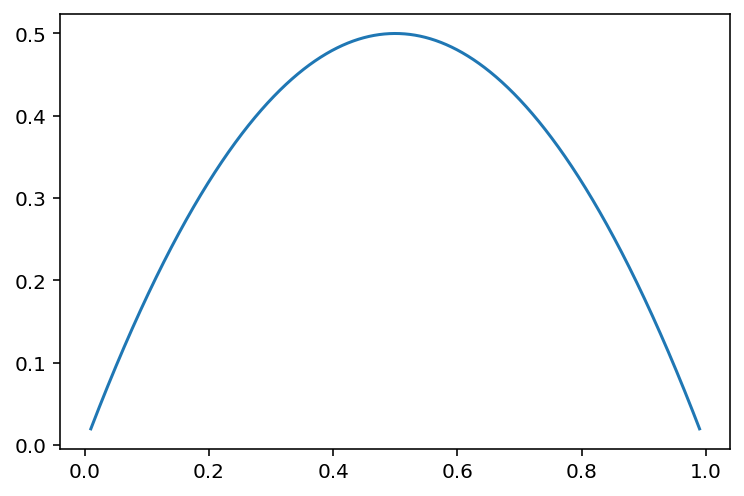

In [10]:
# 通过下图可看到，在0.5信息熵最大，不确定性越高；两级最小，比较稳定。
def second_category_gini(p):
    """二分类基尼系数"""
    return -2 * p **2 + 2*p

x_tmp = np.linspace(0.01, 0.99, 1000000)
y_tmp = second_category_gini(x_tmp)
plt.plot(x_tmp, y_tmp)

### 基尼系数
基于基尼系数实现决策树


In [11]:
from collections import Counter

def split(x, y, d, value): 
    left_index = (x[:, d] <= value)
    right_index = (x[:, d] > value)   
    return x[left_index], x[right_index], y[left_index], y[right_index]

def gini(y):
    """信息熵"""
    counter = Counter(y)
    result = 1
    for num in counter.values():
        p = num / len(y)
        result -= p **2
    return result

def decision_tree(x, y):
    best_entropy = float('inf')
    best_d, best_v = -1, -1
    
    for d in range(x.shape[1]):
        sorted_index = np.argsort(x[:, d])
        for i in range(1, len(x)):
            if x[sorted_index[i-1], d]!=x[sorted_index[i], d]:
                v = (x[sorted_index[i-1], d] + x[sorted_index[i], d]) / 2
                l_x, r_x, l_y, r_y = split(x, y, d, v)
                p_l, p_r = len(l_x)/len(x), len(r_x)/len(x)
                e = p_l * gini(l_y) + p_r * gini(r_y)
                if e < best_entropy:
                    best_entropy, best_d, best_v = e, d, v
    return best_entropy, best_d, best_v            

In [12]:
# 第一层级决策
best_entropy, best_d, best_v = decision_tree(x, y)
print('best_entropy: ', best_entropy)
print('best_d: ', best_d)
print('best_v: ', best_v)

best_entropy:  0.3333333333333333
best_d:  0
best_v:  2.45


In [13]:
# 第二次决策
x1_l, x1_r, y1_l, y1_r = split(x, y, best_d, best_v)

best_entropy2, best_d2, best_v2 = decision_tree(x1_r, y1_r)
print('best_entropy2: ', best_entropy2)
print('best_d2: ', best_d2)
print('best_v2: ', best_v2)

best_entropy2:  0.1103059581320451
best_d2:  1
best_v2:  1.75


结论：信息熵与基尼系数求出的结果基本一致。

## CART与其他超参数

- max_depth: 最大深度
- min_samples_split: 分裂前节点必须有的最小样本数
- min_samples_leaf: 叶节点必须有的最小样本数
- max_leaf_nodes: 最大叶节点数量

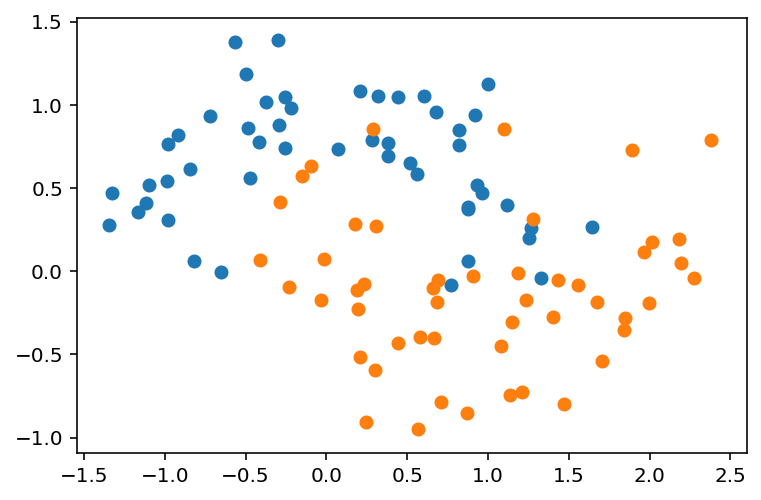

In [14]:
from sklearn import datasets

X, y = datasets.make_moons(noise=0.25, random_state=666)
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### max_depth=2

/Users/gantao/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


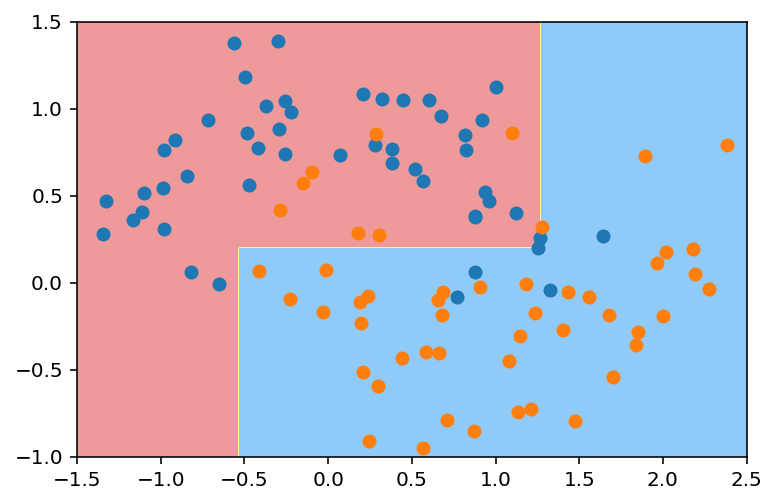

In [15]:
# max_depth=2
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree.export import export_text

dt_clf = DecisionTreeClassifier(max_depth=2)
dt_clf.fit(X, y)

plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### max_depth=20

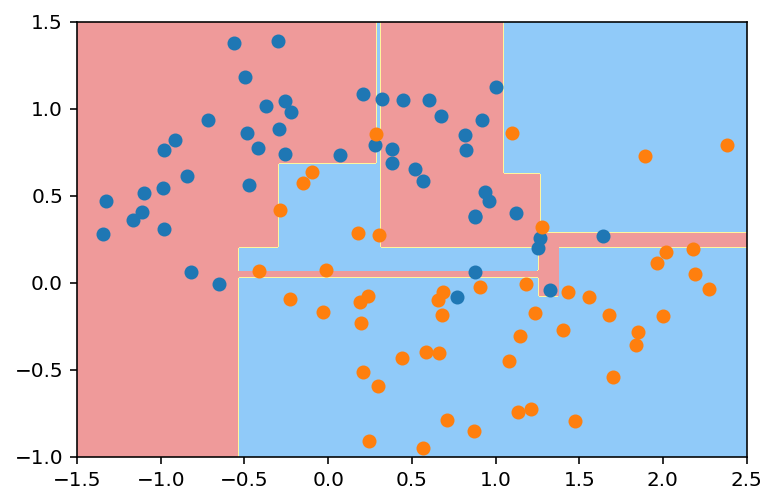

In [16]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree.export import export_text

dt_clf = DecisionTreeClassifier(max_depth=20)
dt_clf.fit(X, y)

plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### min_samples_split=5

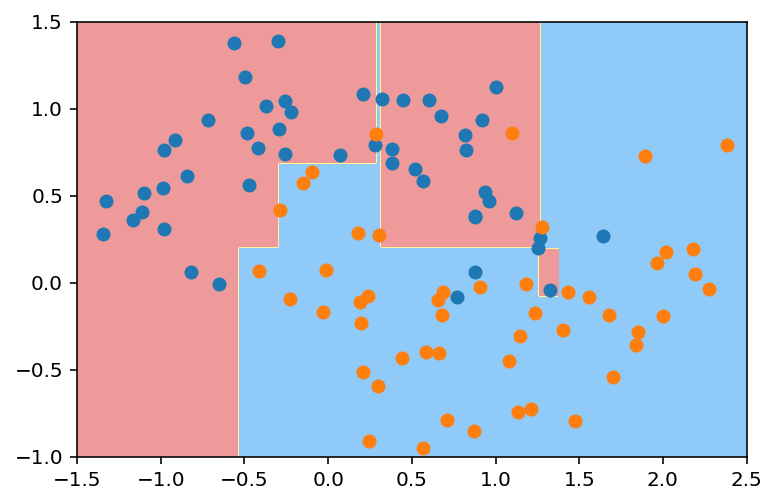

In [17]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree.export import export_text

dt_clf = DecisionTreeClassifier(min_samples_split=5)
dt_clf.fit(X, y)

plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### min_sample_leaf=5
叶子节点最小5个

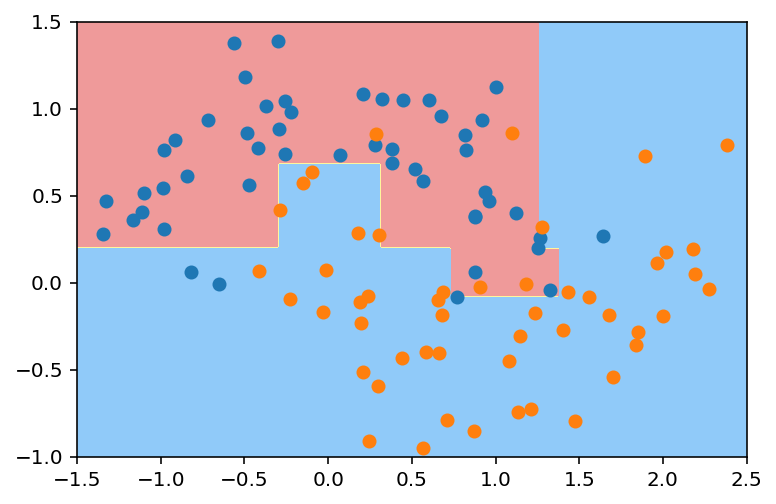

In [18]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree.export import export_text

dt_clf = DecisionTreeClassifier(min_samples_leaf=5)
dt_clf.fit(X, y)

plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### max_leaf_node = 6



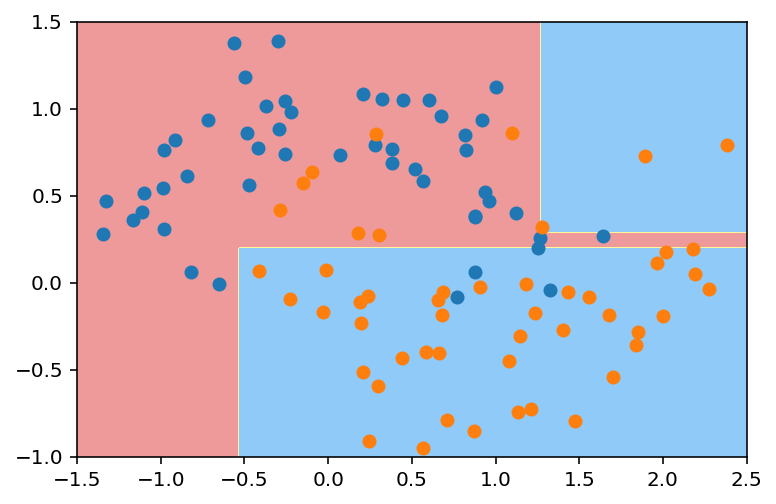

In [19]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree.export import export_text

dt_clf = DecisionTreeClassifier(max_leaf_nodes=6)
dt_clf.fit(X, y)

plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

## 决策树可视化

In [20]:
from sklearn.datasets import load_iris
from sklearn import tree
X, y = load_iris(return_X_y=True)
dt_clf2 = tree.DecisionTreeClassifier(max_depth=3)
dt_clf2.fit(X, y)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### 可视化1

[Text(125.55000000000001, 190.26, 'X[2] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(83.7, 135.9, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(167.4, 135.9, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(83.7, 81.53999999999999, 'X[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(41.85, 27.180000000000007, 'gini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(125.55000000000001, 27.180000000000007, 'gini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(251.10000000000002, 81.53999999999999, 'X[2] <= 4.85\ngini = 0.043\nsamples = 46\nvalue = [0, 1, 45]'),
 Text(209.25, 27.180000000000007, 'gini = 0.444\nsamples = 3\nvalue = [0, 1, 2]'),
 Text(292.95, 27.180000000000007, 'gini = 0.0\nsamples = 43\nvalue = [0, 0, 43]')]

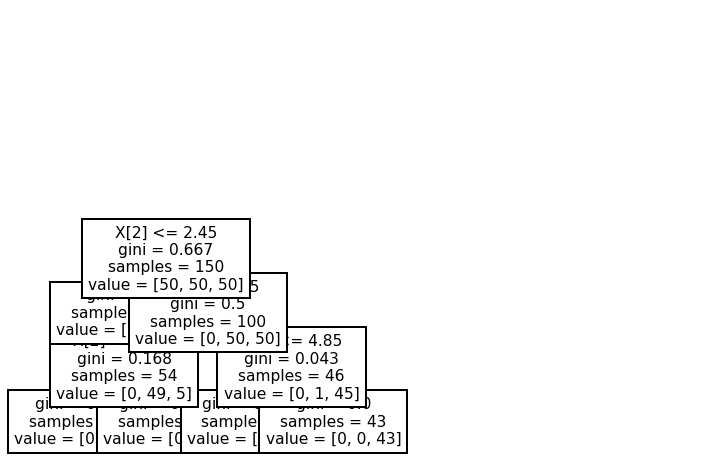

In [21]:
tree.plot_tree(dt_clf2) 

### 可视化2

In [22]:
from sklearn.tree.export import export_text

r = export_text(dt_clf2, feature_names=iris['feature_names'])
print('feature_names: ', iris['feature_names'])
print('\nresult: ')
print(r)

feature_names:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

result: 
|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2



### 可视化3

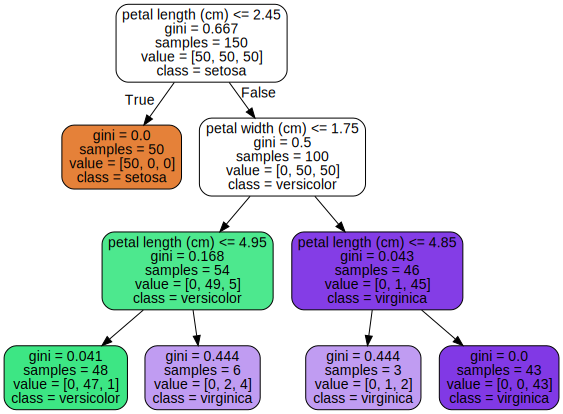

In [23]:
import graphviz 
from sklearn.tree import export_graphviz

dot_data = export_graphviz(dt_clf2, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True) 
graph = graphviz.Source(dot_data) 
graph 